In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv('GiveMeSomeCredit/cs-training.csv', index_col='Unnamed: 0')
test = pd.read_csv('GiveMeSomeCredit/cs-test.csv', index_col='Unnamed: 0')

## Разведочный анализ

In [3]:
train.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


### Исследуем и восполним пропуски

У нас неполный набор `MonthlyIncome` и `NumberOfDependents`

#### `MonthlyIncome`

In [4]:
train["MonthlyIncome"][train["MonthlyIncome"] > 10000]

5         63588.0
10        23684.0
13        12454.0
14        13700.0
16        11362.0
           ...   
149945    24000.0
149967    16000.0
149970    14700.0
149971    15500.0
149992    10316.0
Name: MonthlyIncome, Length: 18319, dtype: float64

MonthlyIncome > 10,000.0: 18319, 0.122%
MonthlyIncome > 20,000.0: 2103, 0.014%
MonthlyIncome > 40,000.0: 449, 0.00299%
MonthlyIncome > 80,000.0: 116, 0.000773%
MonthlyIncome > 160,000.0: 33, 0.00022%
MonthlyIncome > 320,000.0: 16, 0.000107%
MonthlyIncome > 640,000.0: 9, 6e-05%
MonthlyIncome > 1,280,000.0: 3, 2e-05%
MonthlyIncome > 2,560,000.0: 1, 6.67e-06%
MonthlyIncome > 5,120,000.0: 0, 0.0%


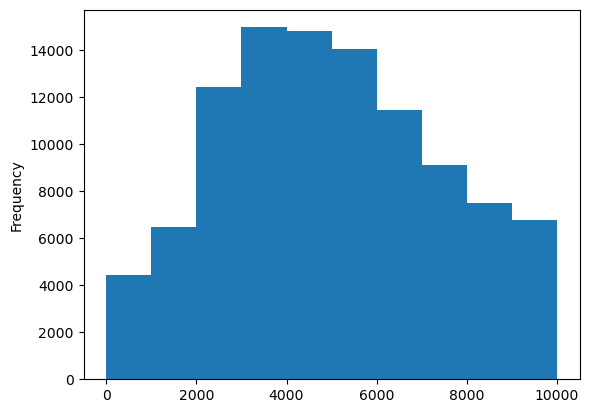

In [5]:
train["MonthlyIncome"][train["MonthlyIncome"] <= 10000].plot(kind='hist');

income = 10e3
while income <= 10e6:
    n_clients = train["MonthlyIncome"][train["MonthlyIncome"] > income].count()
    print(f'MonthlyIncome > {income:,}: {n_clients}, {n_clients/train.shape[0]:.3}%')
    income *= 2

Видим, что имеется несколько очень богатых клиентов, существенно влияющих на среднюю зарплату. Предварительно для восполнения пропусков используем медианное значение

TODO: в дальнейшем можно попробовать, например, kNN

In [6]:
train.fillna({"MonthlyIncome": train["MonthlyIncome"].median()}, inplace=True)

#### `NumberOfDependents`

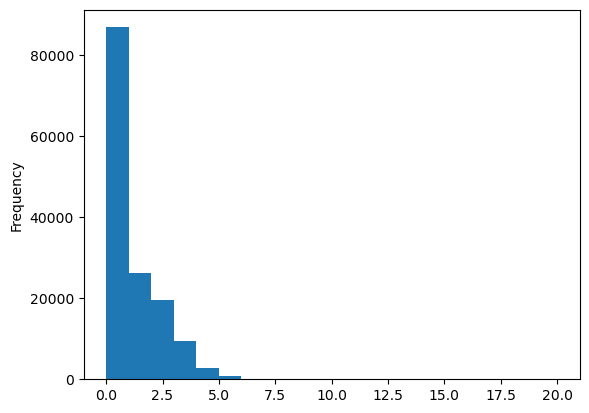

In [7]:
train["NumberOfDependents"].plot(kind='hist', bins=20);

Тут пока тоже заменим на медианное зачение

In [8]:
train["NumberOfDependents"].fillna(train["NumberOfDependents"].median(), inplace=True)

In [9]:
train.isna().sum()

SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64

Все пропуски устранены.

### Теперь обработаем выбросы

In [10]:
train.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.500000e+05,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.418455e+03,8.452760,0.265973,1.018240,0.240387,0.737413
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.289040e+04,5.145951,4.169304,1.129771,4.155179,1.107021
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.903000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,7.400000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


#### `RevolvingUtilizationOfUnsecuredLines`

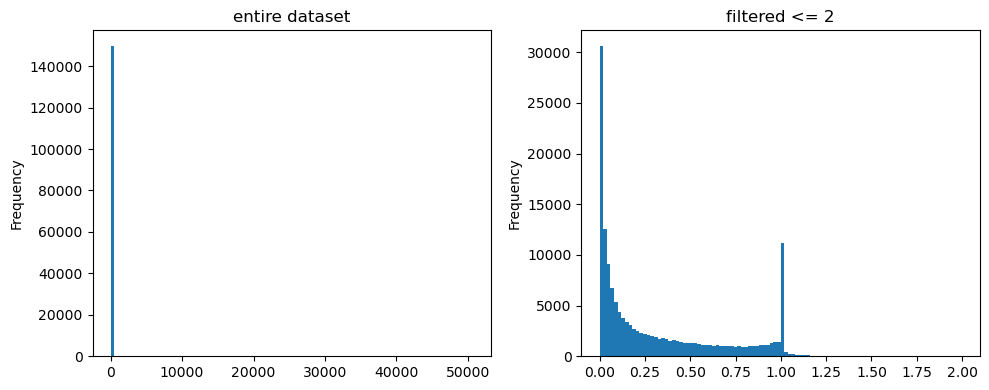

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

train["RevolvingUtilizationOfUnsecuredLines"].plot(kind='hist', bins=100, ax=ax1, title="entire dataset");
train["RevolvingUtilizationOfUnsecuredLines"].loc[train["RevolvingUtilizationOfUnsecuredLines"] <= 2].plot(kind='hist', bins=100, ax=ax2, title="filtered <= 2");

plt.tight_layout()
plt.show()

Сделаем `clip` от 0 до 2

In [12]:
threshold = train["RevolvingUtilizationOfUnsecuredLines"].quantile(0.9973)
train["RevolvingUtilizationOfUnsecuredLines"] = train["RevolvingUtilizationOfUnsecuredLines"].clip(0, threshold)

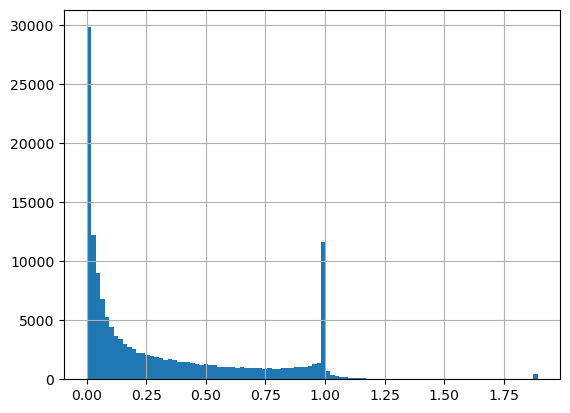

In [13]:
train["RevolvingUtilizationOfUnsecuredLines"].hist(bins=100);

#### `age`

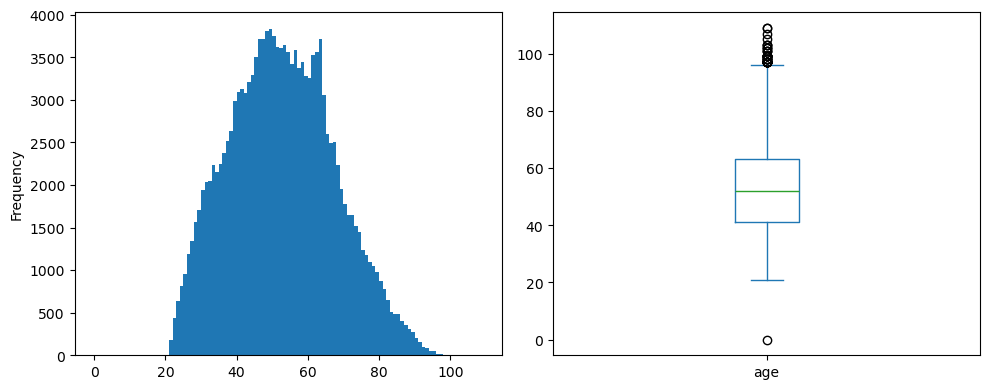

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

train["age"].plot(kind='hist', bins=(train['age'].max() - train['age'].min()), ax=ax1);
train["age"].plot(kind='box', ax=ax2);

plt.tight_layout()
plt.show()

Распределение схоже с нормальным, будем считать выбросы согласно `boxplot` - заменим их на средние значения

In [15]:
age_Q1 = train['age'].quantile(0.25)
age_Q2 = train['age'].quantile(0.50)
age_Q3 = train['age'].quantile(0.75)

IQR = age_Q3 - age_Q1
bottom_fence = age_Q1 - 1.5 * IQR
top_fence = age_Q3 + 1.5 * IQR

mean_age = int(train['age'].mean())
mask = (train['age'] < bottom_fence) | (train['age'] > top_fence)
train.loc[mask, 'age'] = mean_age

In [16]:
print(age_Q1, age_Q2, age_Q3, IQR, top_fence, bottom_fence)

41.0 52.0 63.0 22.0 96.0 8.0


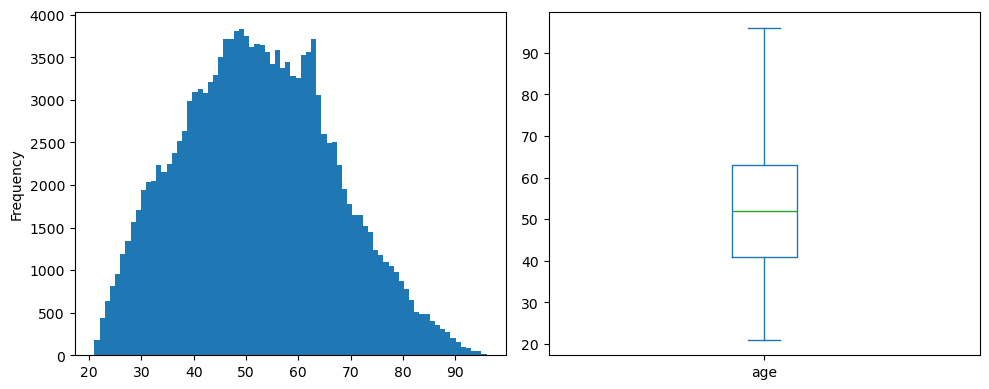

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

train["age"].plot(kind='hist', bins=train['age'].nunique(), ax=ax1);
train["age"].plot(kind='box', ax=ax2);

plt.tight_layout()
plt.show()

#### `NumberOfTime30-59DaysPastDueNotWorse`

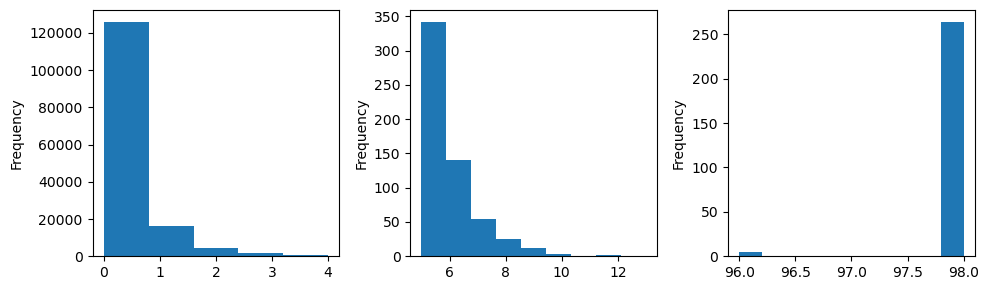

In [18]:
to_4  =  train['NumberOfTime30-59DaysPastDueNotWorse'] <  5
from_5_to_14 = (train['NumberOfTime30-59DaysPastDueNotWorse'] >= 5) & (train['NumberOfTime30-59DaysPastDueNotWorse'] < 14)
from_14      =  train['NumberOfTime30-59DaysPastDueNotWorse'] >= 14

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3))

train['NumberOfTime30-59DaysPastDueNotWorse'].loc[to_4].plot(kind='hist', ax=ax1, bins=5);
train['NumberOfTime30-59DaysPastDueNotWorse'].loc[from_5_to_14].plot(kind='hist', ax=ax2, bins=9);
train['NumberOfTime30-59DaysPastDueNotWorse'].loc[from_14].plot(kind='hist', ax=ax3);

plt.tight_layout()
plt.show()

print()

Будем считать все значения больше 13 выбросами, заменим их медианным значением

In [19]:
train.loc[from_14, 'NumberOfTime30-59DaysPastDueNotWorse'] = train['NumberOfTime30-59DaysPastDueNotWorse'].median()

#### `DebtRatio`

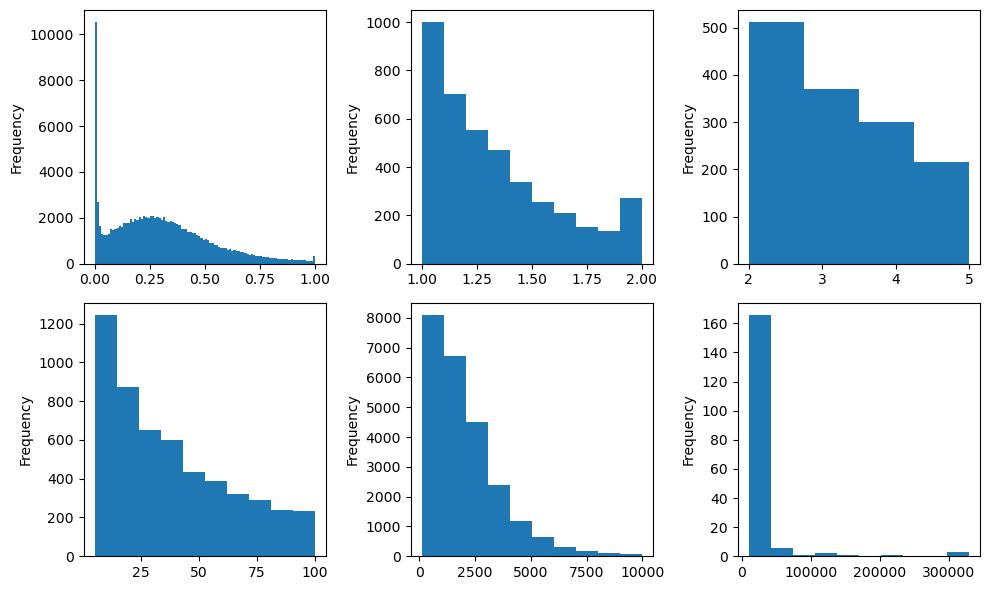

16900
4979.040000000037


In [20]:
to_1  = (train['DebtRatio'] <= 1)
from_1_to_2  = (train['DebtRatio'] > 1) & (train['DebtRatio'] <= 2)
from_2_to_5 = (train['DebtRatio'] > 2) & (train['DebtRatio'] <= 5)
from_5_to_100 = (train['DebtRatio'] > 5) & (train['DebtRatio'] <= 100)
from_100_to_10000 = (train['DebtRatio'] > 100) & (train['DebtRatio'] <= 10000)
from_10000      =  train['DebtRatio'] > 10000

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(10, 6))

train['DebtRatio'].loc[to_1].plot(kind='hist', ax=ax1, bins=100);
train['DebtRatio'].loc[from_1_to_2].plot(kind='hist', ax=ax2, bins=10);
train['DebtRatio'].loc[from_2_to_5].plot(kind='hist', ax=ax3, bins=4);
train['DebtRatio'].loc[from_5_to_100].plot(kind='hist', ax=ax4);
train['DebtRatio'].loc[from_100_to_10000].plot(kind='hist', ax=ax5);
train['DebtRatio'].loc[from_10000].plot(kind='hist', ax=ax6);

plt.tight_layout()
plt.show()

print(train.loc[train['DebtRatio'] >= 1000, 'DebtRatio'].count())
print(train['DebtRatio'].quantile(0.99))

In [22]:
train['DebtRatio_binned'] = train['DebtRatio']

labels = ['0%', '0-15%', '15-30%', '30-45%', '45-60%', '60-75%', '75-100%', '100-150%', '150-200%', '200-500%', '500%+']
bins = [-float('inf'), 0.0, 0.15, 0.3, 0.45, 0.6, 0.75, 1.0, 1.5, 2.0, 5.0, float('inf')]

train['DebtRatio_binned'] = pd.cut(train['DebtRatio'], bins=bins, labels=labels)

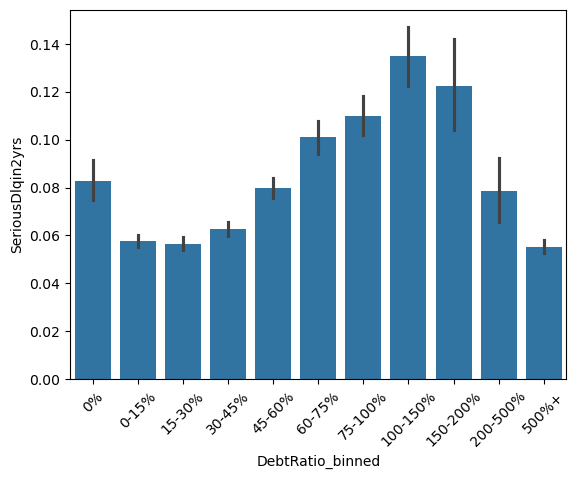

In [23]:
sns.barplot(x=train['DebtRatio_binned'], y=train['SeriousDlqin2yrs']);
plt.xticks(rotation=45)
plt.show()